# <p style="background-color:skyblue; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;">About the Problem 📝 </p>
The aprroach here that this notebook is going to solve is using multiple models based on NLP. Some of them are listed below which this notebook will cover.
1. Using RNN's
2. Using word embeddings like Glove
3. LSTM's
4. GRU
5. Seq2seq mechanism
6. Transformers
7. Attention mechanism

Before every model development i shall be covering the basic concept and architechture behind the mechanism

<html>
    <p style='background:teal; color:coral; font-size:40px; padding:10px;text-align:center'><b>Evaluation metric</b></p>
</html>

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

True Positive Rate
False Positive Rate
True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:

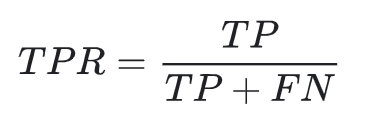

False Positive Rate (FPR) is defined as follows:

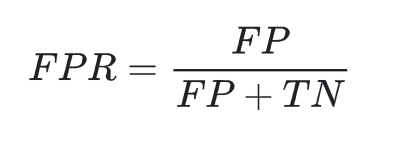

AUC: Area Under the ROC Curve
AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).

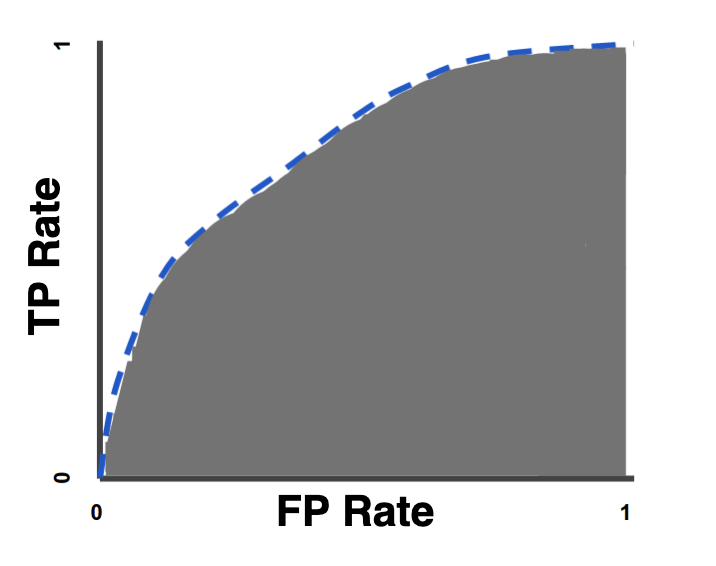

AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example.

AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

## AUC

AUC is desirable for the following two reasons:

AUC is scale-invariant. It measures how well predictions are ranked, rather than their absolute values.
AUC is classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.
However, both these reasons come with caveats, which may limit the usefulness of AUC in certain use cases:

Scale invariance is not always desirable. For example, sometimes we really do need well calibrated probability outputs, and AUC won’t tell us about that.

Classification-threshold invariance is not always desirable. In cases where there are wide disparities in the cost of false negatives vs. false positives, it may be critical to minimize one type of classification error. For example, when doing email spam detection, you likely want to prioritize minimizing false positives (even if that results in a significant increase of false negatives). AUC isn't a useful metric for this type of optimization.


<html>
    <p style='background:teal; color:coral; font-size:40px; padding:10px;text-align:center'><b>Import libraries</b></p>
</html>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

<html>
    <p style='background:teal; color:coral; font-size:40px; padding:10px;text-align:center'><b>Configuring TPU's</b></p>
</html>

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

<html>
    <p style='background:teal; color:coral; font-size:40px; padding:10px;text-align:center'><b>Read the dataset</b></p>
</html>

In [ ]:
train = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
validation = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')

In [ ]:
print(train.shape)
print(validation.shape)
print(test.shape)

## <center>Check some records</center>

In [ ]:
display(train.head())
display(test.head())

### Since there are around 223k records in train set, we shall use a portion of it to train

In [ ]:
train = train.loc[:15000,:]
train.shape

### Drop the columns not required

In [ ]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

### Model evaluation metric : AUC

In [ ]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

### Split the data into Train and Test 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

<html>
    <h1 style='background:gray;  color:pink; font-size:40px; padding:15px; border:5px solid red;'><center><b>1. RNN - Recurrent Neural Network</b></center></h1>
</html>

Recurrent Neural Network is a generalization of feedforward neural network that has an internal memory. RNN is recurrent in nature as it performs the same function for every input of data while the output of the current input depends on the past one computation. After producing the output, it is copied and sent back into the recurrent network. For making a decision, it considers the current input and the output that it has learned from the previous input.
Unlike feedforward neural networks, RNNs can use their internal state (memory) to process sequences of inputs. This makes them applicable to tasks such as unsegmented, connected handwriting recognition or speech recognition. In other neural networks, all the inputs are independent of each other. But in RNN, all the inputs are related to each other. Below is the simple RNN cell.

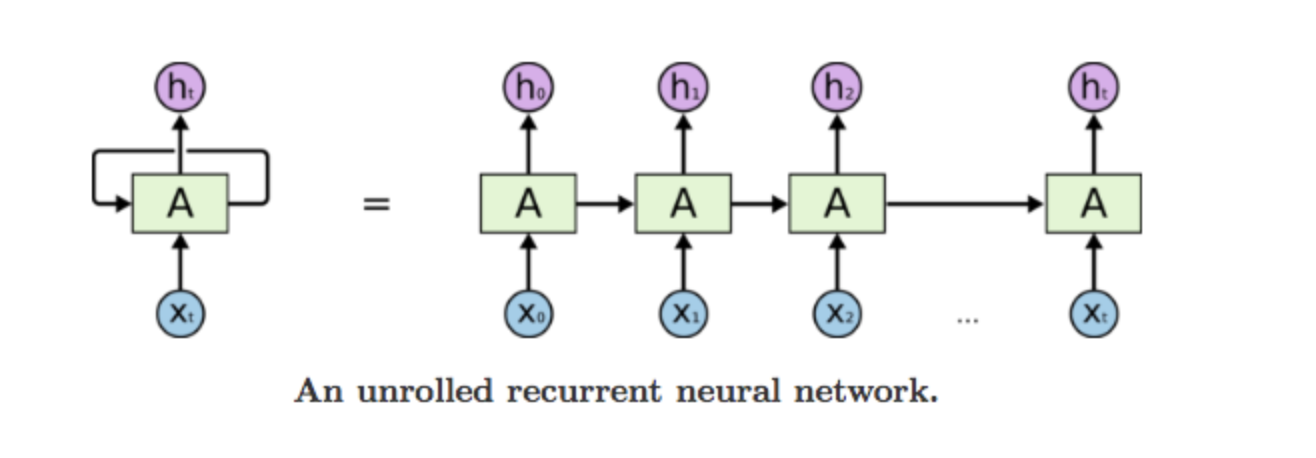

**Advantages of Recurrent Neural Network**
1. RNN can model sequence of data so that each sample can be assumed to be dependent on previous ones
2. Recurrent neural network are even used with convolutional layers to extend the effective pixel neighbourhood.
**Disadvantages of Recurrent Neural Network**
1. Gradient vanishing and exploding problems.
2. Training an RNN is a very difficult task.
3. It cannot process very long sequences if using tanh or relu as an activation function.

### Initiate the RNN architecture

In [ ]:
max_features = 5000
maxlen = 1400

In [ ]:
## Check lenght of text in the data
train['comment_text'].apply(lambda x:len(str(x).split())).max()

In [ ]:
# using keras tokenizer here
token = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)

token.fit_on_texts(list(X_train) + list(X_test))
X_train_seq = token.texts_to_sequences(X_train)
X_test_seq = token.texts_to_sequences(X_test)

#zero pad the sequences
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=maxlen)

word_index = token.word_index

In [ ]:
X_train[0]

In [ ]:
X_train_pad[0]

In [ ]:
len(token.word_index)##49768

### Embedding with Glove 

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
#unzip the file, we get multiple embedding files. We can use either one of them
!unzip glove.6B.zip

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec

#Glove file - we are using model with 50 embedding size
glove_input_file = 'glove.6B.50d.txt'

#Name for word2vec file
word2vec_output_file = 'glove.6B.50d.txt.word2vec'

#Convert Glove embeddings to Word2Vec embeddings
glove2word2vec(glove_input_file, word2vec_output_file)

In [ ]:
### We will extract word embedding for which we are interested in; the pre trained has 400k words each with 50 embedding vector size.
from gensim.models import Word2Vec, KeyedVectors

# Load pretrained Glove model (in word2vec form)
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

#Embedding length based on selected model - we are using 50d here.
embedding_vector_length = 50

In [ ]:
#Initialize embedding matrix
embedding_matrix = np.zeros((max_features + 1, embedding_vector_length))
print(embedding_matrix.shape)

In [ ]:
for word, i in sorted(token.word_index.items(),key=lambda x:x[1]):
    if i > (max_features+1):
        break
    try:
        embedding_vector = glove_model[word] #Reading word's embedding from Glove model for a given word
        embedding_matrix[i] = embedding_vector
    except:
        pass

In [ ]:
embedding_matrix.shape

### Build a simple RNN model

In [ ]:
#Initialize model
import tensorflow as tf
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

In [ ]:
# A simpleRNN without any pretrained embeddings and one dense layer
model = Sequential()
model.add(tf.keras.layers.Embedding(max_features + 1, #Vocablury size
                                    embedding_vector_length, #Embedding size
                                    weights=[embedding_matrix], #Embeddings taken from pre-trained model
                                    trainable=False, #As embeddings are already available, we will not train this layer. It will act as lookup layer.
                                    input_length=maxlen) #Number of words in each review
         )
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

### Fit the model

In [ ]:
history=model.fit(X_train_pad,y_train,
          epochs=10,
          batch_size=32,          
          validation_data=(X_test_pad, y_test))

In [ ]:
test_pred = model.predict(X_test_pad)
print("Auc: %.2f%%" % (roc_auc(test_pred,y_test)))

In [ ]:
test_pred.shape

In [ ]:
test_pred=test_pred.reshape((test_pred.shape[0],))

In [ ]:
test_pred=np.where(test_pred>0.5,1,0)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test,test_pred))
print(classification_report(y_test,test_pred))

In [ ]:
scores_model = []
scores_model.append({'Model': 'SimpleRNN','AUC_Score': round(roc_auc(model.predict(X_test_pad),y_test),2)})

In [ ]:
scores_model

<html>
    <h1 style='background:gray;  color:pink; font-size:40px; padding:15px; border:5px solid red;'><center><b>2. LSTM(Long Short Term Memory)- Improvement over simpleRNN</b></center></h1>
</html>

Long Short-Term Memory (LSTM) networks are a modified version of recurrent neural networks, which makes it easier to remember past data in memory. The vanishing gradient problem of RNN is resolved here. LSTM is well-suited to classify, process and predict time series given time lags of unknown duration. It trains the model by using back-propagation. In an LSTM network, three gates are present:

* Input gate — discover which value from input should be used to modify the memory. Sigmoid function decides which values to let through 0,1. and tanh function gives weightage to the values which are passed deciding their level of importance ranging from-1 to 1.
* Forget gate — discover what details to be discarded from the block. It is decided by the sigmoid function. it looks at the previous state(ht-1) and the content input(Xt) and outputs a number between 0(omit this)and 1(keep this)for each number in the cell state Ct−1.
* Output gate — the input and the memory of the block is used to decide the output. Sigmoid function decides which values to let through 0,1. and tanh function gives weightage to the values which are passed deciding their level of importance ranging from-1 to 1 and multiplied with output of Sigmoid.

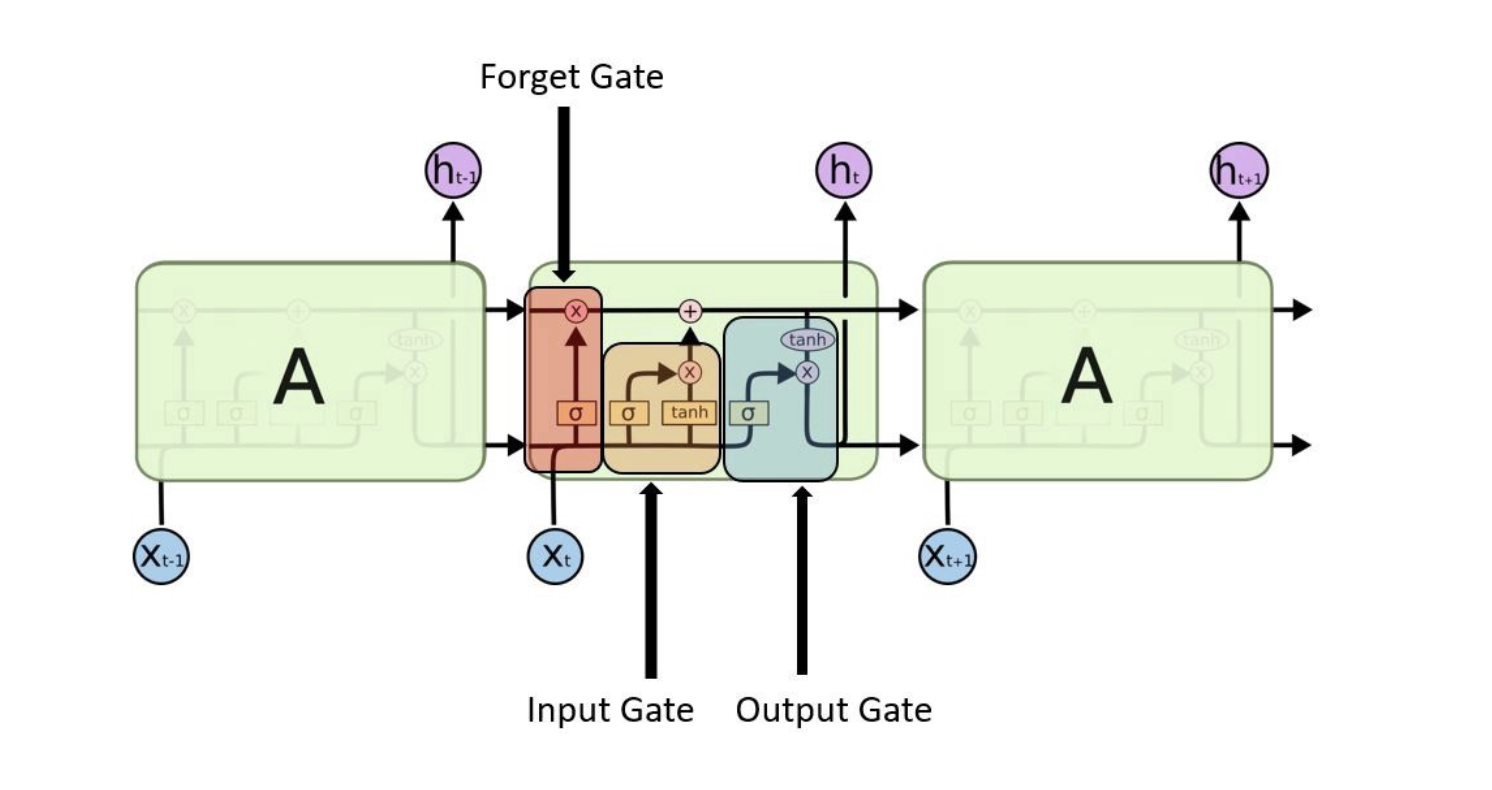

### Embedding with Fasttext

FastText is a vector representation technique developed by facebook AI research. As its name suggests its fast and efficient method to perform same task and because of the nature of its training method, it ends up learning morphological details as well.
FastText is unique because it can derive word vectors for unknown words or out of vocabulary words — this is because by taking morphological characteristics of words into account, it can create the word vector for an unknown word. Since morphology refers to the structure or syntax of the words, FastText tends to perform better for such task, word2vec perform better for semantic task.

In [ ]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English

In [ ]:
!ls -l

In [ ]:
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
### reduct the vector dimension to 50
fasttext.util.reduce_model(ft, 50)

In [ ]:
ft.get_dimension()

### Get word vectors for the words in the train data

In [ ]:
#Initialize embedding matrix
embedding_matrix_fasttext = np.zeros((max_features + 1, embedding_vector_length))
print(embedding_matrix_fasttext.shape)

In [ ]:
for word, i in sorted(token.word_index.items(),key=lambda x:x[1]):
    if i > (max_features+1):
        break
    try:
        embedding_vector = ft[word] #Reading word's embedding from Glove model for a given word
        embedding_matrix_fasttext[i] = embedding_vector
    except:
        pass

In [ ]:
embedding_matrix_fasttext.shape

In [ ]:
len(word_index)

In [ ]:
# A simple LSTM with glove embeddings and one dense layer
model = Sequential()
model.add(Embedding(max_features+1,
                    embedding_vector_length, ### 50 here
                    weights=[embedding_matrix_fasttext],
                    input_length=maxlen, ### 1400 here
                    trainable=False))

model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

### Fit the model

In [ ]:
history=model.fit(X_train_pad,y_train,
          epochs=10,
          batch_size=32,          
          validation_data=(X_test_pad, y_test))

In [ ]:
history.history.keys()

In [ ]:
test_pred = model.predict(X_test_pad)
print("Auc: %.2f%%" % (roc_auc(test_pred,y_test)))

In [ ]:
test_pred.shape

In [ ]:
test_pred=test_pred.reshape((test_pred.shape[0],))

In [ ]:
test_pred=np.where(test_pred>0.5,1,0)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test,test_pred))
print(classification_report(y_test,test_pred))

In [ ]:
scores_model.append({'Model': 'LSTM_with_fasttext','AUC_Score': round(roc_auc(model.predict(X_test_pad),y_test),2)})

In [ ]:
scores_model

<html>
    <h1 style='background:gray;  color:pink; font-size:40px; padding:15px; border:5px solid red;'><center><b>3. GRU - Gated Recurrent Unit</b></center></h1>
</html>

GRU (Gated Recurrent Unit) aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. GRU can also be considered as a variation on the LSTM because both are designed similarly and, in some cases, produce equally excellent results.
To solve the vanishing gradient problem of a standard RNN, GRU uses, so-called, update gate and reset gate. Basically, these are two vectors which decide what information should be passed to the output. The special thing about them is that they can be trained to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction.

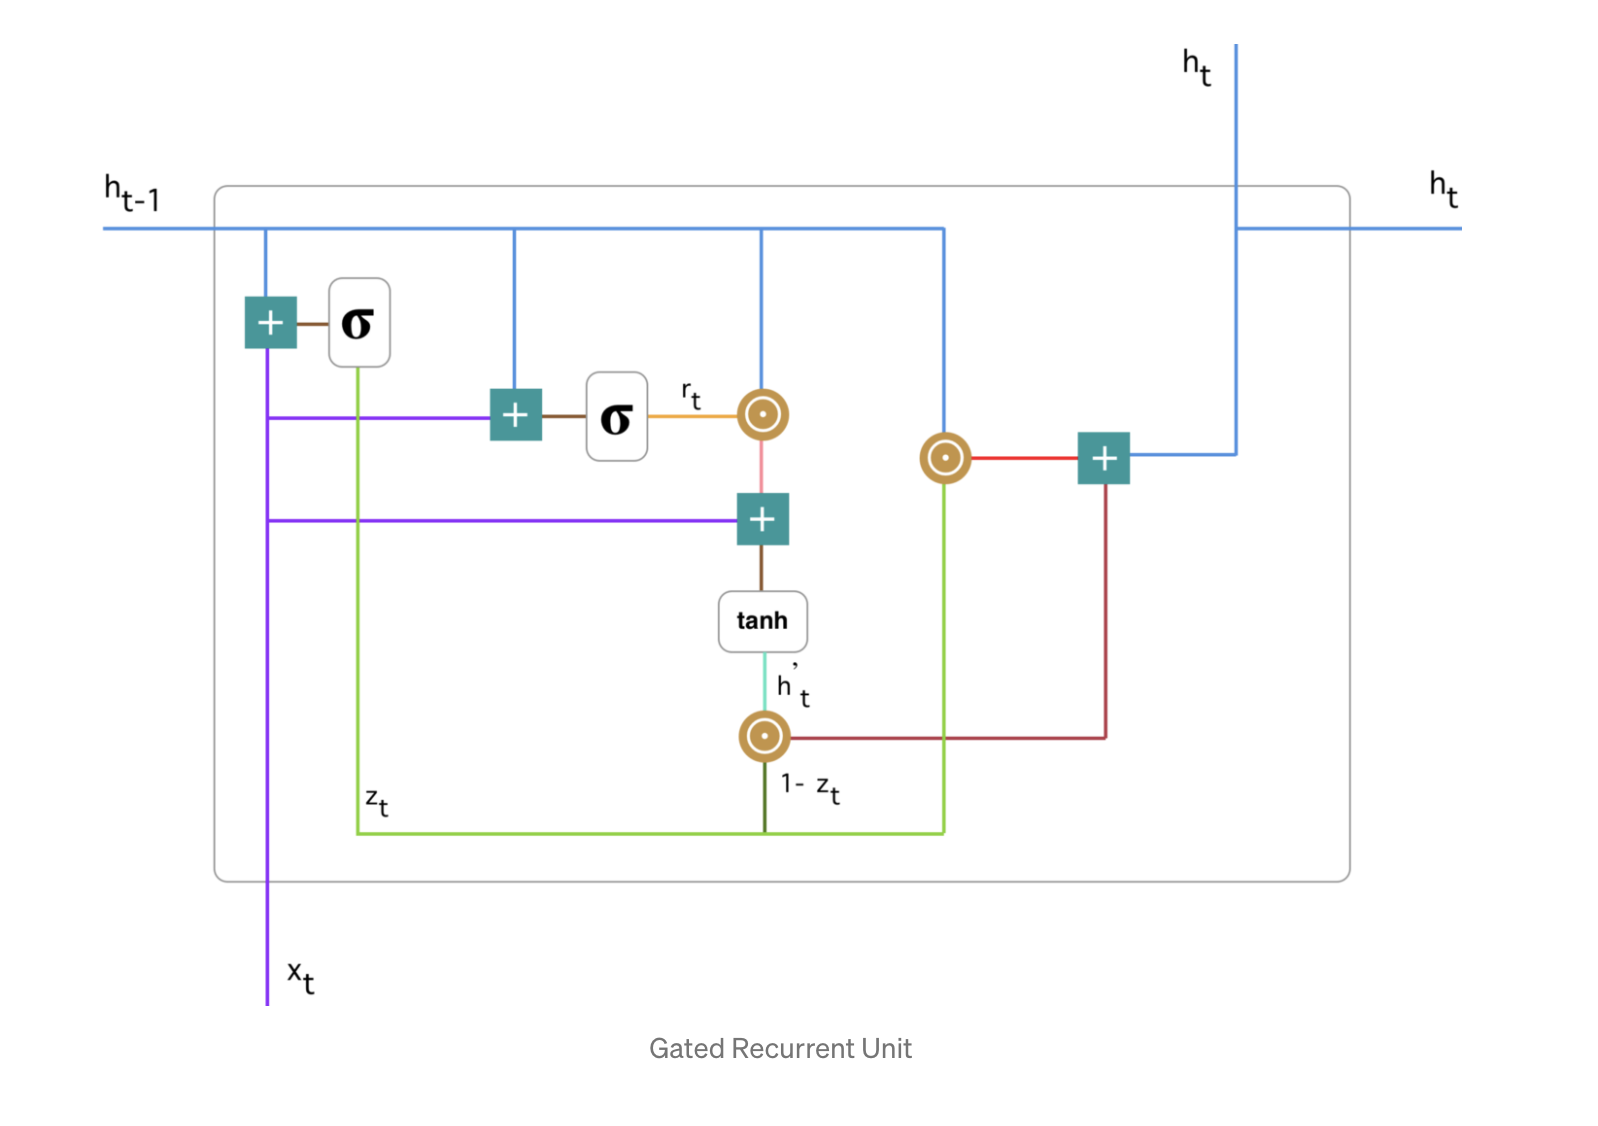

### More about GRU :
https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be

In [ ]:
# GRU with fasttext embeddings
model = Sequential()
model.add(Embedding(max_features+1,
                    embedding_vector_length, ### 50 here
                    weights=[embedding_matrix_fasttext],
                    input_length=maxlen, ### 1400 here
                    trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   

model.summary()

### Fit the model

In [ ]:
history=model.fit(X_train_pad,y_train,
          epochs=10,
          batch_size=32,          
          validation_data=(X_test_pad, y_test))

In [ ]:
test_pred = model.predict(X_test_pad)
print("Auc: %.2f%%" % (roc_auc(test_pred,y_test)))

In [ ]:
test_pred=test_pred.reshape((test_pred.shape[0],))

In [ ]:
test_pred=np.where(test_pred>0.5,1,0)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test,test_pred))
print(classification_report(y_test,test_pred))

In [ ]:
scores_model.append({'Model': 'GRU_with_fasttext','AUC_Score': round(roc_auc(model.predict(X_test_pad),y_test),2)})

In [ ]:
scores_model

<html>
    <h1 style='background:gray;  color:pink; font-size:40px; padding:15px; border:5px solid red;'><center><b>4. Bi-Directional LSTM</b></center></h1>
</html>

Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.
The idea of Bidirectional Recurrent Neural Networks (RNNs) is straightforward.

It involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second.

This approach has been used to great effect with Long Short-Term Memory (LSTM) Recurrent Neural Networks.

The use of providing the sequence bi-directionally was initially justified in the domain of speech recognition because there is evidence that the context of the whole utterance is used to interpret what is being said rather than a linear interpretation.

The use of bidirectional LSTMs may not make sense for all sequence prediction problems, but can offer some benefit in terms of better results to those domains where it is appropriate.



In [ ]:
# A simple bidirectional LSTM with glove embeddings and one dense layer
model = Sequential()
model.add(Embedding(max_features+1,
                    embedding_vector_length, ### 50 here
                    weights=[embedding_matrix],
                    input_length=maxlen, ### 1400 here
                    trainable=False))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

In [ ]:
### we will just run for 1 epoch as it is for understanding purpose
history=model.fit(X_train_pad,y_train,
          epochs=1,
          batch_size=32,          
          validation_data=(X_test_pad, y_test))

In [ ]:
test_pred = model.predict(X_test_pad)
print("Auc: %.2f%%" % (roc_auc(test_pred,y_test)))

<html>
    <h1 style='background:gray;  color:pink; font-size:40px; padding:15px; border:5px solid red;'><center><b>5. Attention Mechanism</b></center></h1>
</html>

The Encoder-Decoder architecture is popular because it has demonstrated state-of-the-art results across a range of domains.

A limitation of the architecture is that it encodes the input sequence to a fixed length internal representation. This imposes limits on the length of input sequences that can be reasonably learned and results in worse performance for very long input sequences.

#### 1. Problem With Long Sequences
The encoder-decoder recurrent neural network is an architecture where one set of LSTMs learn to encode input sequences into a fixed-length internal representation, and second set of LSTMs read the internal representation and decode it into an output sequence.

This architecture has shown state-of-the-art results on difficult sequence prediction problems like text translation and quickly became the dominant approach.

The encoder-decoder architecture still achieves excellent results on a wide range of problems. Nevertheless, it suffers from the constraint that all input sequences are forced to be encoded to a fixed length internal vector.

This is believed to limit the performance of these networks, especially when considering long input sequences, such as very long sentences in text translation problems.

#### 2. Attention within Sequences
Attention is the idea of freeing the encoder-decoder architecture from the fixed-length internal representation.

This is achieved by keeping the intermediate outputs from the encoder LSTM from each step of the input sequence and training the model to learn to pay selective attention to these inputs and relate them to items in the output sequence.

Put another way, each item in the output sequence is conditional on selective items in the input sequence.
This increases the computational burden of the model, but results in a more targeted and better-performing model.

In addition, the model is also able to show how attention is paid to the input sequence when predicting the output sequence. This can help in understanding and diagnosing exactly what the model is considering and to what degree for specific input-output pairs.

#### 3. Self Attention

We are not only talking about architectures bearing the name “BERT’, but more correctly Transformer-based architectures. Transformer-based architectures, which are primarily used in modelling language understanding tasks, eschew the use of recurrence in neural network and instead trust entirely on self-attention mechanisms to draw global dependencies between inputs and outputs.

A self-attention module takes in n inputs, and returns n outputs. What happens in this module? In layman’s terms, the self-attention mechanism allows the inputs to interact with each other (“self”) and find out who they should pay more attention to (“attention”). The outputs are aggregates of these interactions and attention scores.
Illustration:




### Prepare the data 

In [ ]:
#comments and labels
comments = train.comment_text.values
labels = train.toxic.values

In [ ]:
### tokenize data using bert tokenizer
from transformers import *
#Get BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_texts = [tokenizer.tokenize(com) for com in comments]

#We will use only first 200 tokens to do classification (this value can be changed)
max_length = 200
tokenized_texts = [sent[:max_length] for sent in tokenized_texts]

In [ ]:
for i in range(len(tokenized_texts)):
    sent = tokenized_texts[i]
    sent = ['[CLS]'] + sent + ['[SEP]']
    tokenized_texts[i] = sent
    
#Convert tokens into IDs
input_ids = [tokenizer.convert_tokens_to_ids(com) for com in tokenized_texts]

In [ ]:
#Pad our tokens which might be less than max_length size
input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=max_length+2, truncating='post', padding='post')

In [ ]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(input_ids, labels, test_size=0.2, random_state=123)

Create Attention masks : Attention masks are useful to ignore padding tokens. Mask value will be set to 0 for padding tokens and 1 for actual tokens. We will create mask both for training and test data

In [ ]:
# Create attention masks for training
train_attn_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in trainX:
  seq_mask = [float(i>0) for i in seq]
  train_attn_masks.append(seq_mask)

In [ ]:
# Create attention masks for Test
test_attn_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in testX:
  seq_mask = [float(i>0) for i in seq]
  test_attn_masks.append(seq_mask)

In [ ]:
#Load Pre-trained Bert Model with a Binary Classification layer at the top.
#Huggingface library provides TFBertForSequenceClassification for the same
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

In [ ]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule 
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model.summary()

In [ ]:
train_x_data = {'input_ids': np.array(trainX), 'attention_mask': np.array(train_attn_masks)}
test_x_data = {'input_ids': np.array(testX), 'attention_mask': np.array(test_attn_masks)}

In [ ]:
model.fit(train_x_data, trainY, validation_data=(test_x_data, testY), batch_size=16, epochs=2)

In [ ]:
test_pred = model.predict(test_x_data)[0]
### this object return scored before softmax

In [ ]:
test_pred
### scores before softmax

In [ ]:
tf_prediction = tf.nn.softmax(test_pred, axis=1).numpy()
## this will return probability score

In [ ]:
tf_prediction=np.argmax(tf_prediction,axis=1)
## this will return predicted class labels

In [ ]:
np.unique(tf_prediction)

In [ ]:
print("Auc: %.2f%%" % (roc_auc(tf_prediction,testY)))

<html>
    <p style='background:teal; color:coral; font-size:40px; padding:10px;text-align:center'><b>Take away Notes</b></p>
</html>
1. This notebook is completely for the understanding purpost and hence the outputs are not shown completely for every model architechture.
2. The number of epochs are also kept low for couple of architechtures as it is a time taking training tasks.
3. For Bi directional LSTM and BERT models i have used GPU for training.
4. Loading embedding from fastText is time consuming process.